<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [2]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': False, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 5327, 'maxbars': 100000, 'codepage': 0, 'ping_last'

In [3]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [4]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "USD" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

280
Yes  EURUSD
Yes  GBPUSD
Yes  USDJPY
Yes  USDCHF
Yes  AUDUSD
Yes  NZDUSD
Yes  USDCAD
Yes  USDMXN
Yes  USDZAR
Yes  XAGUSD
Yes  XAUUSD
Yes  XBRUSD
Yes  XTIUSD
Yes  XNGUSD
Yes  BTCUSD
Yes  ETHUSD
Yes  LTCUSD
Yes  XRPUSD
Yes  BCHUSD
Yes  AAVEUSD
Yes  ADAUSD
Yes  ALGOUSD
Yes  ATOMUSD
Yes  AVAXUSD
Yes  AXSUSD
Yes  BNBUSD
Yes  DASHUSD
Yes  DOGEUSD
Yes  DOTUSD
Yes  FILUSD
Yes  GRTUSD
Yes  ICPUSD
Yes  IOTAUSD
Yes  LINKUSD
Yes  LRCUSD
Yes  MANAUSD
Yes  NEARUSD
Yes  SOLUSD
Yes  UNIUSD
Yes  ZECUSD
Yes  ETCUSD
Yes  TRXUSD
Yes  FETUSD
Yes  ARBUSD
Yes  APTUSD
Yes  SUIUSD
Yes  USDDKK
Yes  USDCZK
Yes  USDHUF
Yes  USDNOK
Yes  USDPLN
Yes  USDSEK
Yes  USDSGD
Yes  USDHKD
Yes  USDCNH
Yes  USDTRY
Yes  XBRUSD.Daily
Yes  XTIUSD.Daily
Yes  BTCUSD.Daily
Yes  ETHUSD.Daily
Yes  XRPUSD.Daily
Yes  LTCUSD.Daily
Yes  BCHUSD.Daily
Yes  LINKUSD.Daily
Yes  SOLUSD.Daily
65


In [ ]:
market = mt5.copy_rates_from_pos(t_symbol[0], mt5.TIMEFRAME_H1, 0, 99999)
display(market)

array([(1251374400, 1.42654, 1.4275 , 1.42551, 1.42554, 2320, 20, 0),
       (1251378000, 1.4255 , 1.42816, 1.4254 , 1.42773, 2302, 20, 0),
       (1251381600, 1.42774, 1.42818, 1.42469, 1.4256 , 3678, 20, 0), ...,
       (1759525200, 1.17335, 1.17399, 1.17265, 1.17393, 2009,  8, 0),
       (1759528800, 1.1739 , 1.17418, 1.17369, 1.17405, 1529,  8, 0),
       (1759532400, 1.17408, 1.17444, 1.1738 , 1.1738 , 1423,  8, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [5]:
test_symbol = []
for t_s in t_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_H1, 0, 99999)
    if(len(market) > 80000 and market[0][4] < 1):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" dbot.csv", index=False)
        test_symbol.append(t_s)


In [6]:

for t_s in test_symbol:
    market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_D1, 0, 1000)
    if(len(market) > 900):
        data = []
        for i in range(len(market)):
            data.append([market[i][1],market[i][2],market[i][3],market[i][4]])
        df = pd.DataFrame(data, columns=["open", "high","low", "close"])
        df.to_csv("Generated"+t_s+" test.csv", index=False)



In [ ]:
import joblib

joblib.dump(t_symbol,"symbol.joblib")

['symbol.joblib']

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2.10.1


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import joblib
import os
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [7]:
# Get the list of all files and directories in the specified path

dir_contents = os.listdir(".")
t_symbol = joblib.load("symbol.joblib")

In [19]:
print(t_symbol)

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCHF', 'AUDUSD', 'NZDUSD', 'USDCAD', 'USDMXN', 'USDZAR', 'XAGUSD', 'XAUUSD', 'XBRUSD', 'XTIUSD', 'XNGUSD', 'BTCUSD', 'ETHUSD', 'LTCUSD', 'XRPUSD', 'BCHUSD', 'AAVEUSD', 'ADAUSD', 'ALGOUSD', 'ATOMUSD', 'AVAXUSD', 'AXSUSD', 'BNBUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'FILUSD', 'GRTUSD', 'ICPUSD', 'IOTAUSD', 'LINKUSD', 'LRCUSD', 'MANAUSD', 'NEARUSD', 'SOLUSD', 'UNIUSD', 'ZECUSD', 'ETCUSD', 'TRXUSD', 'FETUSD', 'ARBUSD', 'APTUSD', 'SUIUSD', 'USDDKK', 'USDCZK', 'USDHUF', 'USDNOK', 'USDPLN', 'USDSEK', 'USDSGD', 'USDHKD', 'USDCNH', 'USDTRY', 'XBRUSD.Daily', 'XTIUSD.Daily', 'BTCUSD.Daily', 'ETHUSD.Daily', 'XRPUSD.Daily', 'LTCUSD.Daily', 'BCHUSD.Daily', 'LINKUSD.Daily', 'SOLUSD.Daily']


In [6]:
#t_symbol = ["EURUSD","AUDUSD","GBPUSD","USDCAD"]

In [9]:

# Filter the list to include only files, not directories
# os.path.join is used to create a full path for isfile() to check
files = [item for item in dir_contents]

file_target = []
test_target = []

for filename in files:
    for t_s in t_symbol:
        if t_s in filename  and "dbot.csv" in filename:
            print(filename)
            file_target.append(filename)
            test_target.append(filename.replace("dbot","test"))

print("----------------------------------------------------")

print(len(file_target))
print(len(test_target))
train_dfs = []
for f_t in file_target:
    train_dfs.append(pd.read_csv(f_t))

train_dfs_test = []
for f_t in test_target:
    train_dfs_test.append(pd.read_csv(f_t))

GeneratedAUDUSD dbot.csv
GeneratedNZDUSD dbot.csv
----------------------------------------------------
2
2


In [7]:
display(train_dfs[0])

,open,high,low,close
0,0.84057,0.84059,0.83818,0.83867
1,0.83869,0.83914,0.83827,0.83865
2,0.83866,0.83950,0.83863,0.83927
3,0.83928,0.84099,0.83778,0.83974
4,0.83973,0.84158,0.83926,0.84040
...,...,...,...,...
99994,0.65906,0.65922,0.65839,0.65879
99995,0.65878,0.65936,0.65865,0.65931
99996,0.65935,0.65977,0.65915,0.65974
99997,0.65976,0.66068,0.65920,0.66063


In [9]:
display(train_dfs_test[0])

,open,high,low,close
0,0.71238,0.71324,0.70817,0.71097
1,0.71060,0.71557,0.70982,0.71521
2,0.71501,0.72199,0.71203,0.72115
3,0.72088,0.72513,0.71916,0.72398
4,0.72398,0.72435,0.72156,0.72161
...,...,...,...,...
995,0.65754,0.66277,0.65703,0.66112
996,0.66105,0.66279,0.65886,0.66109
997,0.66117,0.66238,0.65761,0.65939
998,0.65933,0.66134,0.65882,0.65999


In [10]:
print(train_dfs[0].values[:,-1:])

[[0.83867]
 [0.83865]
 [0.83927]
 ...
 [0.65974]
 [0.66063]
 [0.66061]]


In [10]:
def create_sequences(data_scaled, seq_len, pred_steps = 5):
    """
    data_scaled: np.array shaped (n_rows, n_features)
    returns X (n_samples, seq_len, n_features), y (n_samples, n_features)
    where y is the row immediately following the window.
    """
    X, y = [], []
    n_rows = data_scaled.shape[0]
    for i in range(n_rows - seq_len - pred_steps + 1):
        X.append(data_scaled[i:i+seq_len])
        y.append(data_scaled[i+seq_len : i + seq_len+pred_steps, -1])
    X = np.array(X)
    y = np.array(y)
    return X, y





In [11]:
n = 0

In [12]:
m_label = file_target[n].replace("dbot.csv","")
train_df = train_dfs[n]
train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 240 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape

X, y = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
X1, y1 = create_sequences(train_df.values, SEQ_LEN, 5)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)

n_samples = X.shape[0]


GeneratedAUDUSD 


In [37]:
print(X[-1])

[[0.6421  0.64316 0.64205 0.64256]
 [0.64256 0.64944 0.64253 0.64925]
 [0.64925 0.65004 0.64826 0.64827]
 [0.64827 0.64914 0.64827 0.64877]
 [0.64877 0.64976 0.64877 0.64943]
 [0.64942 0.64965 0.64882 0.64883]
 [0.64883 0.64889 0.64841 0.64874]
 [0.64875 0.64927 0.64869 0.64895]
 [0.64879 0.64922 0.64879 0.64914]
 [0.64913 0.64933 0.64834 0.64872]
 [0.64872 0.6489  0.64833 0.64841]
 [0.64842 0.64852 0.64794 0.6483 ]
 [0.6483  0.64845 0.6471  0.64721]
 [0.64721 0.64808 0.64716 0.64803]
 [0.64803 0.6488  0.64803 0.64864]
 [0.64864 0.64915 0.64864 0.64889]
 [0.64889 0.6495  0.64883 0.64919]
 [0.6492  0.65045 0.6492  0.64999]
 [0.64999 0.65003 0.64853 0.64859]
 [0.64859 0.64984 0.64859 0.64951]
 [0.6495  0.64953 0.64857 0.64885]
 [0.64886 0.64911 0.64859 0.64893]
 [0.64894 0.64988 0.64891 0.64983]
 [0.64983 0.6499  0.64907 0.64914]
 [0.64915 0.65006 0.64883 0.64974]
 [0.64974 0.65038 0.64949 0.64994]
 [0.64994 0.65033 0.64951 0.64977]
 [0.64977 0.64992 0.64938 0.64958]
 [0.64957 0.64963 0.

In [33]:
print(y[-2])

[0.65549 0.65516 0.65517 0.65546 0.65831]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = Bidirectional(LSTM(200, return_sequences=True))(i)
X = Bidirectional(LSTM(200, return_sequences=True))(X)
X = Bidirectional(LSTM(200, return_sequences=True))(X)
X = Bidirectional(LSTM(200))(X)
#X = Dropout(0.5)(X)
X = Dense(150, activation="relu")(X)
X = Dropout(0.5)(X)
X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 4)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 240, 400)         328000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 240, 400)         961600    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 240, 400)         961600    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              961600    
 nal)                                                        

In [14]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  #batch_size=1024,
  callbacks=[es, rlr, mc ],
  verbose=1

)




Epoch 1/100


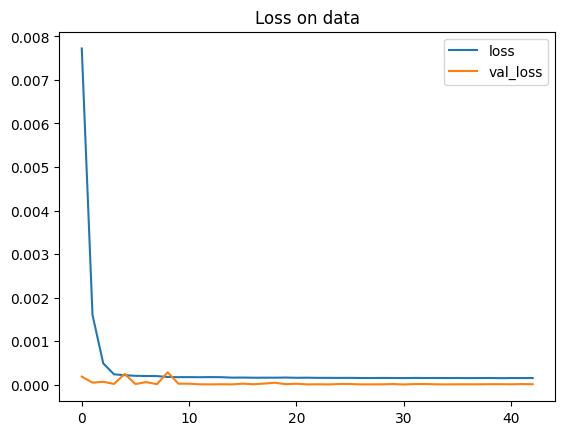

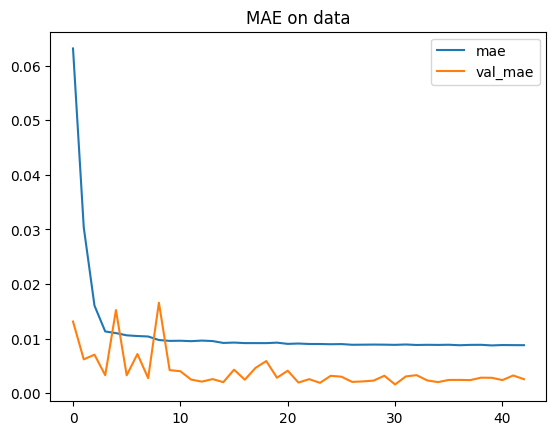

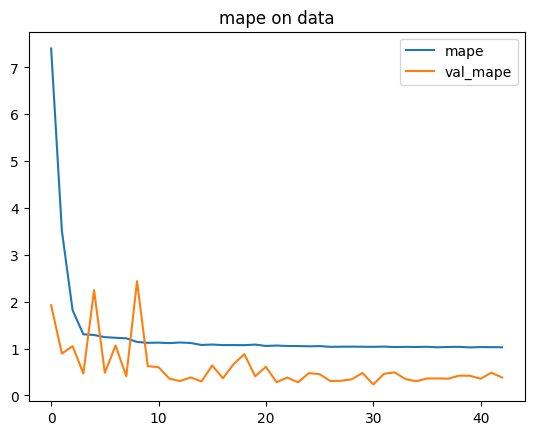

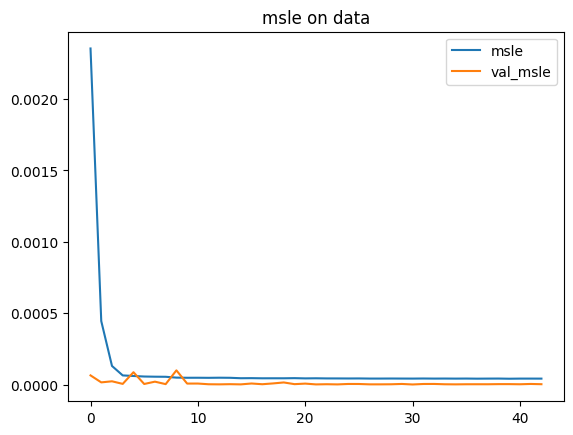

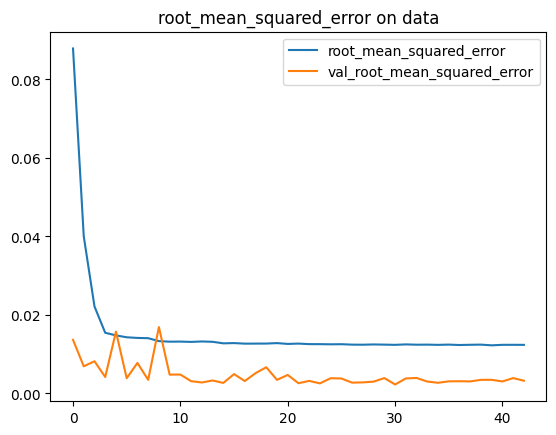

In [40]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [41]:
best_model = load_model(m_label + 'lstm_best.keras')


In [42]:
best_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 4)]          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 240, 400)         328000    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 240, 400)         961600    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 240, 400)         961600    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 400)              961600    
 onal)                                                     

In [43]:
best_model.evaluate(X1,y1)

 332/3118 [==>...........................] - ETA: 2:12 - loss: 1.4559e-05 - mae: 0.0028 - root_mean_squared_error: 0.0038 - mape: 0.3028 - msle: 3.9594e-06

KeyboardInterrupt: 

In [47]:
y_pred = best_model.predict(X_test)

11/11 [==============================] - 1s 46ms/step


In [48]:
print(y_test, " comparing to ", y_pred)

[[0.64902 0.64911 0.64934 ... 0.64864 0.64884 0.64789]
 [0.64911 0.64934 0.64939 ... 0.64884 0.64789 0.64901]
 [0.64934 0.64939 0.64935 ... 0.64789 0.64901 0.64851]
 ...
 [0.65401 0.65712 0.65877 ... 0.65516 0.65517 0.65546]
 [0.65712 0.65877 0.65564 ... 0.65517 0.65546 0.65831]
 [0.65877 0.65564 0.65672 ... 0.65546 0.65831 0.65863]]  comparing to  [[0.64911157 0.64912194 0.64917445 ... 0.64911705 0.6491786  0.64932853]
 [0.6489623  0.6489727  0.64902526 ... 0.64896774 0.6490294  0.64917946]
 [0.64890385 0.6489142  0.64896685 ... 0.6489092  0.6489709  0.64912105]
 ...
 [0.6540427  0.6540556  0.6541031  ... 0.65405506 0.6541065  0.65425795]
 [0.65354574 0.6535586  0.65360624 ... 0.6535578  0.6536096  0.6537616 ]
 [0.65569717 0.65570986 0.655757   ... 0.65571034 0.6557607  0.65591025]]


In [49]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))

R^2 value for  GeneratedAUDUSD 
0.8687540694075089


In [50]:
y_pred = best_model.predict(X1)
print("R^2 value for test ", m_label)
print(r2_score(y1, y_pred))

3118/3118 [==============================] - 143s 46ms/step
R^2 value for test  GeneratedAUDUSD 
0.9995593957582634


In [52]:
print(y1[-1], " comparing to ", y_pred[-1])

[0.65877 0.65564 0.65672 0.6563  0.65549 0.65516 0.65517 0.65546 0.65831
 0.65863]  comparing to  [0.6556973  0.65571004 0.6557571  0.6558425  0.6557368  0.6557678
 0.6557008  0.65571046 0.6557608  0.65591043]


In [ ]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[:, -1], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()



plt.figure(figsize=(12, 6))
plt.plot(y1[:, -1], label='Actual Close Price', color='blue')
plt.plot(y_pred[:, -1], label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs. Predicted Close Price Test')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()